## Import the libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import keras.backend as K

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from lr_utils.keras_lr_finder import LRFinder
from lr_utils.keras_SGDR import SGDRScheduler
from lr_utils.keras_CLR import CyclicLR, CLR

### Load the dataset

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [10]:
num_classes = 10
batch_size = 128
epochs=5

In [11]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Create a Network

The loss function has to be **categorical_crossentropy** since we deal with categorical labels.
The same goes for the last activation which has to be **softmax** since we have more than two classes (sigmoid would be fine for two classes).

In [12]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


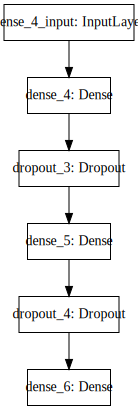

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Find the optimal Learning Rate

This method has been proposed by Leslie Smith. The concept to find the best learning rate is to begin at a small one, and increase it progressively. By looking at the loss function for the values of the Learning Rate, we can see it being very stable (no improvement) when the LR is small, then drop faster and faster and finally oscillate and diverge when the LR is too big. The optimal LR stands in the middle, where the slope is the steepest (not at the minimum of the curve).

In [14]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-2, step_size=np.ceil(X_train.shape[0]/batch_size))
model.fit(X_train, y_train, callbacks=[lr_finder] )

Epoch 1/1
25856/60000 [===========>..................] - ETA: 8s - loss: 1.8174 - acc: 0.3983

Raw loss values

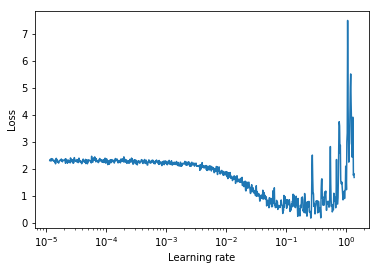

In [15]:
lr_finder.plot_loss()

Smoothed loss values. It is now easier to find the optimal learning rate

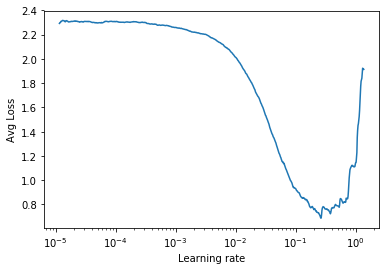

In [16]:
lr_finder.plot_avg_loss()

The optimal learning rate is in the part of the graph where the slope is the steepest, here between 2e-2 and 1e-1. We want to take the highest learning rate without taking too much risks (close from the minimum). A good value seems to be 7e-2.

## Cyclical Learning Rate and Momentum

In [17]:
clr = CLR(min_lr=7e-3, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing=0.1, step_size=np.ceil(((X_train.shape[0]*epochs)/(batch_size*2))))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 103us/step - loss: 2.8845 - acc: 0.7328 - val_loss: 0.1768 - val_acc: 0.9464
Epoch 2/5
60000/60000 [==============================] - 6s 104us/step - loss: 0.2009 - acc: 0.9400 - val_loss: 0.1316 - val_acc: 0.9609
Epoch 3/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.1464 - acc: 0.9567 - val_loss: 0.0994 - val_acc: 0.9680
Epoch 4/5
60000/60000 [==============================] - 6s 101us/step - loss: 0.1118 - acc: 0.9659 - val_loss: 0.0895 - val_acc: 0.9734
Epoch 5/5
60000/60000 [==============================] - 6s 100us/step - loss: 0.0855 - acc: 0.9737 - val_loss: 0.0754 - val_acc: 0.9775


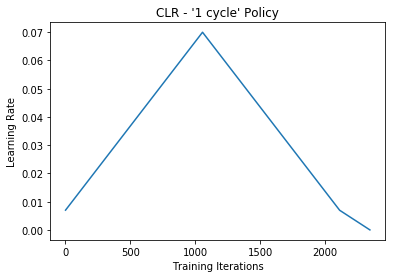

In [19]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - '1 cycle' Policy")
plt.plot(clr.history['iterations'], clr.history['lr'])

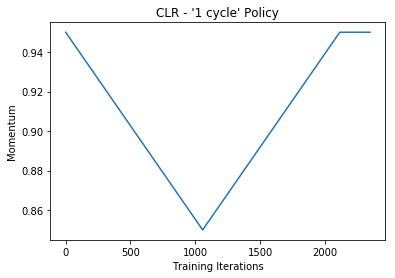

In [20]:
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("CLR - '1 cycle' Policy")
plt.plot(clr.history['iterations'], clr.history['momentum'])

## Stochastic Gradient Descent with Restart (SGDR)

In [21]:
schedule = SGDRScheduler(min_lr=7e-3,max_lr=7e-2,steps_per_epoch=np.ceil(X_train.shape[0]/batch_size), lr_decay=0.9, cycle_length=1,mult_factor=1.5)
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[schedule])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.0732 - acc: 0.9778 - val_loss: 0.0729 - val_acc: 0.9782
Epoch 2/5
60000/60000 [==============================] - 6s 100us/step - loss: 0.0720 - acc: 0.9781 - val_loss: 0.0731 - val_acc: 0.9782
Epoch 3/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.0676 - acc: 0.9792 - val_loss: 0.0717 - val_acc: 0.9790
Epoch 4/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.0716 - acc: 0.9784 - val_loss: 0.0717 - val_acc: 0.9792
Epoch 5/5
60000/60000 [==============================] - 6s 99us/step - loss: 0.0668 - acc: 0.9798 - val_loss: 0.0700 - val_acc: 0.9792


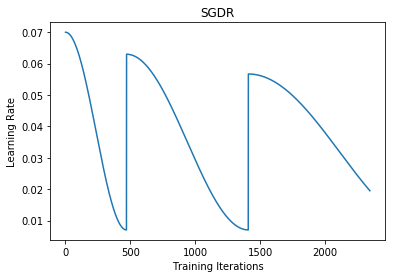

In [23]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("SGDR")
plt.plot(schedule.history['iterations'], schedule.history['lr'])

## Cyclical Learning Rate (CLR)

In [24]:
clr_triangular = CyclicLR(mode='triangular', step_size=np.ceil((X_train.shape[0]/batch_size)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 127us/step - loss: 0.2020 - acc: 0.9429 - val_loss: 0.1915 - val_acc: 0.9423
Epoch 2/5
60000/60000 [==============================] - 8s 125us/step - loss: 0.1878 - acc: 0.9488 - val_loss: 0.0908 - val_acc: 0.9729
Epoch 3/5
60000/60000 [==============================] - 8s 126us/step - loss: 0.1479 - acc: 0.9585 - val_loss: 0.2162 - val_acc: 0.9445
Epoch 4/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1909 - acc: 0.9506 - val_loss: 0.0975 - val_acc: 0.9726
Epoch 5/5
60000/60000 [==============================] - 8s 131us/step - loss: 0.1391 - acc: 0.9613 - val_loss: 0.2004 - val_acc: 0.9492


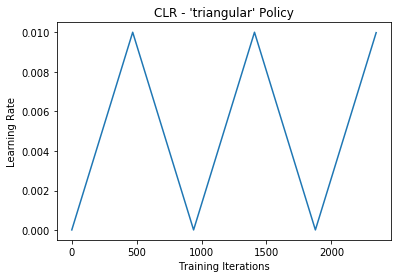

In [26]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [27]:
clr_triangular = CyclicLR(mode='triangular2', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data= (X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 127us/step - loss: 0.1895 - acc: 0.9537 - val_loss: 0.1945 - val_acc: 0.9513
Epoch 2/5
60000/60000 [==============================] - 8s 127us/step - loss: 0.1889 - acc: 0.9541 - val_loss: 0.1126 - val_acc: 0.9727
Epoch 3/5
60000/60000 [==============================] - 8s 129us/step - loss: 0.1109 - acc: 0.9709 - val_loss: 0.1024 - val_acc: 0.9726
Epoch 4/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.1016 - acc: 0.9724 - val_loss: 0.0924 - val_acc: 0.9775
Epoch 5/5
60000/60000 [==============================] - 8s 126us/step - loss: 0.0725 - acc: 0.9799 - val_loss: 0.0923 - val_acc: 0.9765


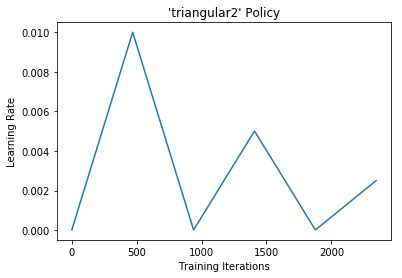

In [29]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [30]:
clr_triangular._reset()

In [31]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.1364 - acc: 0.9663 - val_loss: 0.2499 - val_acc: 0.9501
Epoch 2/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.2358 - acc: 0.9456 - val_loss: 0.1141 - val_acc: 0.9726
Epoch 3/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1228 - acc: 0.9686 - val_loss: 0.1245 - val_acc: 0.9693
Epoch 4/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.1032 - acc: 0.9723 - val_loss: 0.0934 - val_acc: 0.9771
Epoch 5/5
60000/60000 [==============================] - 8s 127us/step - loss: 0.0806 - acc: 0.9776 - val_loss: 0.0989 - val_acc: 0.9765


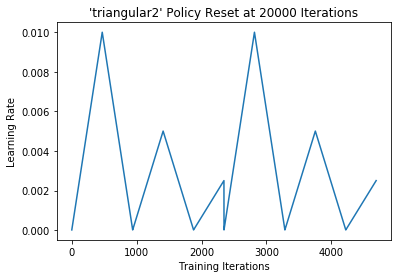

In [32]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy Reset at 20000 Iterations")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [33]:
clr_triangular = CyclicLR(mode='exp_range', step_size=np.ceil(X_train.shape[0]/batch_size), gamma=0.9994)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 139us/step - loss: 0.1109 - acc: 0.9718 - val_loss: 0.1650 - val_acc: 0.9668
Epoch 2/5
60000/60000 [==============================] - 8s 127us/step - loss: 0.1218 - acc: 0.9693 - val_loss: 0.1016 - val_acc: 0.9756
Epoch 3/5
60000/60000 [==============================] - 8s 129us/step - loss: 0.0847 - acc: 0.9781 - val_loss: 0.1044 - val_acc: 0.9753
Epoch 4/5
60000/60000 [==============================] - 8s 132us/step - loss: 0.0823 - acc: 0.9784 - val_loss: 0.0947 - val_acc: 0.9781
Epoch 5/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.0705 - acc: 0.9810 - val_loss: 0.1030 - val_acc: 0.9780


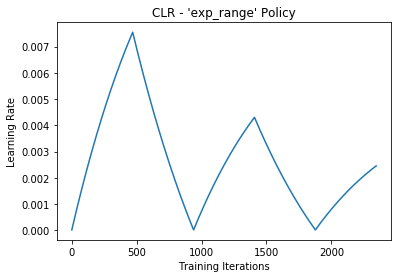

In [35]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'exp_range' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [36]:
clr_triangular._reset(new_base_lr=0.003, new_step_size=np.ceil(X_train.shape[0]/batch_size), new_max_lr=0.009)

In [37]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 132us/step - loss: 0.1178 - acc: 0.9718 - val_loss: 0.1546 - val_acc: 0.9656
Epoch 2/5
60000/60000 [==============================] - 9s 154us/step - loss: 0.1455 - acc: 0.9662 - val_loss: 0.1157 - val_acc: 0.9730
Epoch 3/5
60000/60000 [==============================] - 9s 148us/step - loss: 0.0991 - acc: 0.9750 - val_loss: 0.1292 - val_acc: 0.9754
Epoch 4/5
60000/60000 [==============================] - 9s 156us/step - loss: 0.0934 - acc: 0.9762 - val_loss: 0.1135 - val_acc: 0.9767
Epoch 5/5
60000/60000 [==============================] - 8s 135us/step - loss: 0.0799 - acc: 0.9798 - val_loss: 0.1262 - val_acc: 0.9750


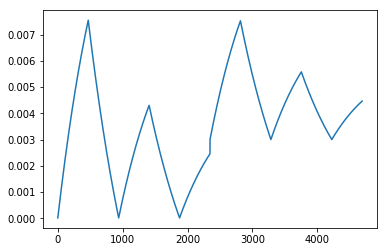

In [38]:
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [39]:
clr = lambda x: 0.5*(1+np.sin(x*np.pi/2.))

In [40]:
clr_triangular = CyclicLR(scale_fn=clr, scale_mode='cycle', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.1237 - acc: 0.9727 - val_loss: 0.1796 - val_acc: 0.9605
Epoch 2/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1641 - acc: 0.9642 - val_loss: 0.1169 - val_acc: 0.9751
Epoch 3/5
60000/60000 [==============================] - 8s 131us/step - loss: 0.0923 - acc: 0.9773 - val_loss: 0.1191 - val_acc: 0.9760
Epoch 4/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.0873 - acc: 0.9790 - val_loss: 0.1132 - val_acc: 0.9772
Epoch 5/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.0632 - acc: 0.9834 - val_loss: 0.1131 - val_acc: 0.9770


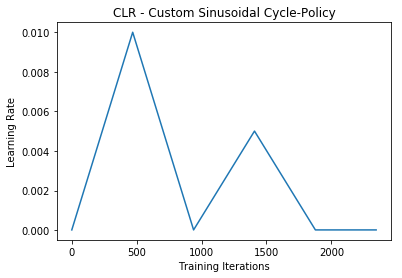

In [42]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Sinusoidal Cycle-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [43]:
clr = lambda x: 1/(5**(x*0.0001))

In [44]:
clr_triangular = CyclicLR(scale_fn=clr, scale_mode='iterations', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1102 - acc: 0.9750 - val_loss: 0.2116 - val_acc: 0.9530
Epoch 2/5
60000/60000 [==============================] - 8s 127us/step - loss: 0.1556 - acc: 0.9675 - val_loss: 0.1309 - val_acc: 0.9745
Epoch 3/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.1170 - acc: 0.9743 - val_loss: 0.1455 - val_acc: 0.9704
Epoch 4/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1168 - acc: 0.9724 - val_loss: 0.1119 - val_acc: 0.9782
Epoch 5/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.0874 - acc: 0.9776 - val_loss: 0.1352 - val_acc: 0.9726


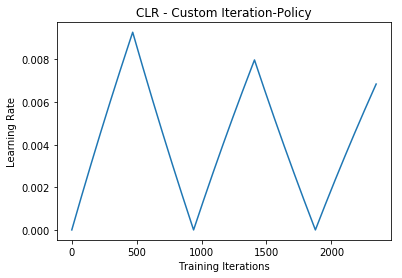

In [46]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Iteration-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])